In [1]:
def execute_sql_script_from_file(file_path, dbname="synthea", user="admin", password="adminpassword", host="localhost", port="5432"):
    if not os.path.isfile(file_path):
        return [False, f"SQL file not found: {file_path}"]
    
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            sql_script = f.read()
        conn = psycopg2.connect(
            dbname=dbname,
            user=user,
            password=password,
            host=host,
            port=port
        )
        conn.autocommit = True
        cursor = conn.cursor()
        print(f"Executing SQL script for database '{dbname}' from file: {file_path}")
        cursor.execute(sql_script)
        if cursor.description:
            colnames = [desc[0] for desc in cursor.description]
            rows = cursor.fetchall()
            df = pd.DataFrame(rows, columns=colnames)
            return [True, df.to_string()]
        
        return [True, "SQL executed successfully with no results to display."]
    except Exception as e:
        return [False, f"SQL Execution Error: {str(e)}"]

    except psycopg2.Error as e:
        error_msg = f"[{dbname}] SQL Execution Error: {e}"
        print(error_msg)
        return [False, error_msg]

    except Exception as e:
        error_msg = f"[{dbname}] Unexpected Error: {e}"
        print(error_msg)
        return [False, error_msg]

    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

TOGETHER_API_KEY = "bdd4a08692807d05983219eec866289d342941595cb1dd726d2ec128404dd4d1"

def together_chat_completion_clean(prompt, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"):
    
    time.sleep(1)
    url = "https://api.together.xyz/v1/chat/completions"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {TOGETHER_API_KEY}"
    }
    data = {
        "model": model,
        "messages": prompt,  
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    
    if response.status_code != 200:
        raise Exception(f"Erreur API: {response.status_code} - {response.text}")
    
    response_json = response.json()
    content = response_json.get("choices", [{}])[0].get("message", {}).get("content", "")

    return content.strip()


def extract_and_append_sql(text, json_data, sql_file_path):
    sql_blocks = re.findall(r"```sql\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        sql_blocks = re.findall(r"```\s*sql\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        sql_blocks = re.findall(r"```[a-zA-Z]*\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    
    if not sql_blocks:
        print(f"❌ Aucun bloc SQL trouvé pour l'étape {json_data.get('id', 'unknown')}")
        print(f"Texte analysé (premiers 200 chars): {text[:200]}")
        return
    
    step_id = json_data.get("id", "unknown")
    
    os.makedirs(os.path.dirname(sql_file_path), exist_ok=True)
    
    with open(sql_file_path, "a", encoding="utf-8") as f:
        for block in sql_blocks:
            f.write(f"-- BEGIN STEP: {step_id}\n")
            f.write(block.strip() + "\n")
            f.write(f"-- END STEP: {step_id}\n\n")
    
    print(f"✅ Ajouté {len(sql_blocks)} bloc(s) SQL pour l'étape {step_id} dans {sql_file_path}")

def edit_sql_file(id: int, sql_script: str, file_named: str):
    begin_marker = f"-- BEGIN STEP: {id}"
    end_marker = f"-- END STEP: {id}"

    with open(file_named, 'r') as file:
        lines = file.readlines()

    start_index = None
    end_index = None

    for i, line in enumerate(lines):
        if line.strip() == begin_marker:
            start_index = i
        elif line.strip() == end_marker:
            end_index = i
            break

    if start_index is None or end_index is None or start_index >= end_index:
        raise ValueError(f"STEP with id {id} not found in the file.")

    new_script_lines = [begin_marker + '\n'] + [line + '\n' for line in sql_script.strip().split('\n')] + [end_marker + '\n']
    lines = lines[:start_index] + new_script_lines + lines[end_index + 1:]

    with open(file_named, 'w') as file:
        file.writelines(lines)


In [2]:
import requests
import json
import re
import psycopg2
import pandas as pd
import os 
import time 
from unitest_OMOP import unittest_location_table

folder = "json/location/"
conversation_history = []

with open("prompt/prompt1.txt", "r", encoding="utf-8") as f:
    prompt = f.read()

system_message = {
    "role": "system",
    "content": prompt
}

conversation_history.append(system_message)

for idx, file_name in enumerate(sorted(os.listdir(folder))):
    path = os.path.join(folder, file_name)
    if not os.path.isfile(path):
        continue

    with open(path, "r", encoding="utf-8") as f:
        json_data = json.load(f)
    json_str = json.dumps(json_data, indent=2)

    conversation_history.append({
        "role": "user",
        "content": f"Here is the JSON:\n\n{json_str}"
    })

    full_context = "\n\n".join([m["content"] for m in conversation_history])
    llm_response = together_chat_completion_stream_clean(full_context, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")

    extract_and_append_sql(llm_response, json_data, "SQL/location.sql")

    conversation_history.append({
        "role": "assistant",
        "content": llm_response
    })

with open("conversation_history.json", "w") as f:
    json.dump(conversation_history, f, indent=2)


```sql
-- Section 0 start

CREATE VIEW location_enriched_view AS
SELECT 
    p.city,
    p.state,
    p.zip,
    sm.state_abbreviation
FROM 
    synthea_source.patients p
LEFT JOIN 
    omop.state_map sm ON p.state = sm.state;

-- Section 0 end
```✅ Ajouté 1 bloc(s) SQL pour l'étape 0 dans SQL/location.sql


Exception: Erreur API: 429 - {
  "id": "nwV1bFU-6UHjtw-94956f2cafedd169",
  "error": {
    "message": "You have reached the rate limit specific to this model meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo. The maximum rate limit for this model is 6.0 queries and 180000000 tokens per minute. This limit differs from the general rate limits published at Together AI rate limits documentation (https://docs.together.ai/docs/rate-limits). For inquiries about increasing your model-specific rate limit, please contact our sales team (https://www.together.ai/forms/contact-sales)",
    "type": "model_rate_limit",
    "param": null,
    "code": null
  }
}

In [ ]:
cleanup_location_table("synthea")
result = execute_sql_script_from_file("SQL/location.sql", dbname="synthea")
print(result)

In [ ]:

i=0

def cleanup_location_table(dbname="synthea"):
    """Nettoie la table location avant réexécution"""
    cleanup_sql = """
    DROP VIEW IF EXISTS omop.location_enriched_view;
    DELETE FROM omop.location;
    """
    return execute_sql_script_from_file(cleanup_sql,dbname="synthea")


while i < 3 :
    cleanup_location_table("synthea")
    result = execute_sql_script_from_file("SQL/location.sql", dbname="synthea")

    if result[0]:
        success_msg = f"# ✅ SQL executed successfully.\n\n{result[1]}" 
        test_msg = unittest_location_table(user="admin", password="adminpassword", host="localhost", port="5432", database="synthea")
        conversation_history.append({
            "role": "ipython",
            "content": success_msg +"\n\n"+ test_msg
        })
    else:
        error_msg = f"# ❌ SQL Execution Error:\n{result[1]}"
        conversation_history.append({
            "role": "ipython",
            "content": error_msg
        })

    full_context = "\n\n".join([m["content"] for m in conversation_history])
    llm_response = together_chat_completion_stream_clean(full_context, model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")

    conversation_history.append({
        "role": "assistant",
        "content": llm_response
    })
    
    pattern = r'<function=([a-zA-Z_]+)>({.*?})<\/function>'
    
    # FIX: Process function calls properly
    function_calls_found = False
    for match in re.finditer(pattern, llm_response, re.DOTALL):
        function_calls_found = True
        function_name = match.group(1)
        function_args_raw = match.group(2)
        
        try:
            function_args = json.loads(function_args_raw)
            
            if function_name == "edit_sql_file":
                sql_script = function_args.get("sql_script")
                id = function_args.get("id")
                file_named = function_args.get("file_named")
                edit_sql_file(id, sql_script, file_named)
                print(f"Edited SQL for step {id}")
        except Exception as e:
            print(f"Error processing function call: {e}")
        
    if contains_task_completed(llm_response):
        print("✅ Task completed.")
        break
    i = i +1 

with open("conversation_history.json", "w") as f:
    json.dump(conversation_history, f, indent=2)

print(f"\nProcessed {len(conversation_history)} messages.")

In [26]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, Tuple, Union, List
from unitest_OMOP import unittest_location_table

unit_test_map = {"location": unittest_location_table}

class AgentState(TypedDict):
    prompt: Union[str, List[dict]]
    target_table: str
    test_result: Tuple[str, bool, str]
    sql_result: Tuple[bool, str]
    retry_count: int

def load_json(table_name):
    folder = "json/location/"
    
    with open("prompt/prompt1.txt", "r", encoding="utf-8") as f:
        prompt = f.read()
    
    system_message = {"role": "system", "content": prompt}
    conversation_history = [system_message]
    collected_jsons = []
    collected_sql = []
    last_json_data = None
    
    for idx, file_name in enumerate(sorted(os.listdir(folder))):
        path = os.path.join(folder, file_name)
        if not os.path.isfile(path):
            continue
            
        with open(path, "r", encoding="utf-8") as f:
            json_data = json.load(f)
        
        json_str = json.dumps(json_data, indent=2)
        collected_jsons.append(f"JSON {idx}:\n{json_str}")
        
        conversation_history.append({
            "role": "ipython", 
            "content": f"Here is JSON number {idx}:\n\n{json_str}"
        })
        
        llm_response = together_chat_completion_stream_clean(
            prompt=conversation_history,
            model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"
        )
        extract_and_append_sql(llm_response, json_data, "SQL/location.sql")
        
        conversation_history.append({"role": "assistant", "content": llm_response})
        last_json_data = json_data
    
    target_table_raw = last_json_data.get("target_table", "") if last_json_data else ""
    target_table = target_table_raw.split(".")[-1].lower() if "." in target_table_raw else target_table_raw.lower()
    test_named = unit_test_map[target_table]
    file_name = f"{target_table}.sql"
    with open(f"SQL/{file_name}" , 'r', encoding='utf-8') as fichier:
        contenu_sql = fichier.read()
    final_prompt = [
        {"role": "system", "content": prompt.strip()},
        {"role": "ipython", "content": "\n\n".join(collected_jsons).strip() + "\n\nSQL Code:\n" + contenu_sql}]

    return AgentState(
        test_result = (test_named, False,""),
        sql_result = (False, ""), 
        prompt =final_prompt,
        target_table = target_table
    )
    

def all_tests_passed(json_input):
    if isinstance(json_input, str):
        data = json.loads(json_input)
    else:
        data = json_input
    return data.get("overall_status") == "passed"

def run_sql(state: AgentState) -> AgentState:
    table_name = state.get('target_table', '')
    
    result = execute_sql_script_from_file("SQL/" +table_name + '.sql')
    test_info = state.get('test_result', ("", False, ""))
    
    if result[0]:
        test_info = state.get('test_result')
        
        if test_info[1] and callable(test_info[0]):
            test_result = test_info[0]()  
            bool_info = all_tests_passed(test_result)
            unitest_msg = {"role": "ipython", "content": result[1] + str(test_result)}
            prompt.append(unitest_msg)
            return AgentState(
                test_result=(test_info[0], bool_info, str(test_result)),
                sql_result=(True , result[1] ),
                prompt=prompt,
                target_table=state.get('target_table', "")
            )
    else: 

        error_msg = {"role": "ipython", "content": result[1] }
        prompt.append(error_msg)
        return AgentState(
            test_result=(test_info[0], False, test_info[2],
            sql_result=(False , result[1]),
            prompt=prompt,
            target_table=state.get('target_table', ""))
            
def fix_sql(state: AgentState) -> AgentState:
    
    prompt = state.get('prompt') 
    llm_response = together_chat_completion_stream_clean(prompt=prompt,model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")
    prompt.append({
        "role": "assistant",
        "content": llm_response
    })
    pattern = r'<function=([a-zA-Z_]+)>({.*?})<\/function>'
    function_calls_found = False
    for match in re.finditer(pattern, llm_response, re.DOTALL):
        function_calls_found = True
        function_name = match.group(1)
        function_args_raw = match.group(2)
        function_args = json.loads(function_args_raw)
        if function_name == "edit_sql_file":
            sql_script = function_args.get("sql_script")
            id = function_args.get("id")
            file_named = function_args.get("file_named")
            edit_sql_file(id, sql_script, file_named)
    return AgentState(
            test_result=state.get('test_result') ,
            sql_result=state.get('sql_result'),
            prompt=prompt,
            target_table=state.get('target_table'))
    
def check_completion(state: AgentState) -> AgentState:
    sql = state.get("sql_result")[0]
    unitest = state.get("test_result")[1] 
    
    if sql and unitest:
        return "complete"
    elif sql == False:
        return "retry"
    elif unitest == False:
        return "retry"




SyntaxError: invalid syntax. Perhaps you forgot a comma? (3854123471.py, line 68)

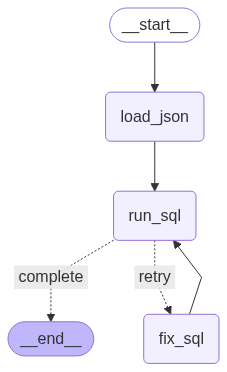

In [25]:
graph = StateGraph(AgentState)

graph.add_node("load_json", load_json)
graph.add_node("run_sql", run_sql)
graph.add_node("fix_sql", fix_sql)  

graph.add_conditional_edges("run_sql", check_completion, {
    "complete": END,
    "retry": "fix_sql",
    "failed": END
})

graph.set_entry_point("load_json") 

graph.add_edge("load_json", "run_sql")
graph.add_edge("fix_sql", "run_sql")

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))